In [42]:
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import string

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chingyiie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chingyiie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chingyiie/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv("data/airlines_twitter.csv")

### Keywords Analysis

In [46]:
keywords = ['air','airplane','aeroplane','airways','aircraft','airline','airlines','plane','flight','flights','fly',
            'flying', 'airport','aviation','lax','customs','travel','travels','traveling','traveler',
            'corona','coronavirus','covid','covid-19','coronavirusoutbreak','coronaviruspandemic','virus',
            'coronavirusupdates']

def process_text(text):
    nopunc_digit = [char for char in text.lower() if char not in string.punctuation and not char.isdigit()]
    nopunc_digit = ''.join(nopunc_digit)

    wnl = WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(word) for word in nopunc_digit.split() if not wnl.lemmatize(word) in set(stopwords.words('english'))]
    lemmatized = ' '.join(lemmatized)
    
    filtered = [word for word in lemmatized.split() if word not in keywords]
    filtered = ' '.join(filtered)
    
    doc = nlp(filtered)
    final = [token.text for token in doc if (token.pos_ == 'ADJ' or token.pos_ == 'ADV')]
    final = ' '.join(final)
    
    return final

corpus = df['text'].apply(process_text)

In [47]:
bow_transformer = CountVectorizer(max_features = 1000).fit(corpus)
bow = bow_transformer.transform(corpus)

sum_words = bow.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in bow_transformer.vocabulary_.items()]

words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [48]:
words_freq

[('due', 411),
 ('new', 221),
 ('still', 203),
 ('latest', 181),
 ('safe', 177),
 ('global', 166),
 ('back', 160),
 ('many', 138),
 ('international', 133),
 ('even', 132),
 ('home', 125),
 ('pandemic', 110),
 ('also', 103),
 ('positive', 102),
 ('right', 97),
 ('last', 95),
 ('full', 93),
 ('next', 90),
 ('temporarily', 89),
 ('good', 88),
 ('abroad', 87),
 ('free', 84),
 ('close', 82),
 ('empty', 81),
 ('long', 81),
 ('first', 77),
 ('live', 76),
 ('important', 72),
 ('soon', 72),
 ('public', 71),
 ('best', 71),
 ('really', 70),
 ('much', 70),
 ('travelban', 68),
 ('healthy', 65),
 ('nonessential', 63),
 ('great', 61),
 ('open', 59),
 ('better', 58),
 ('least', 57),
 ('medical', 57),
 ('never', 56),
 ('american', 53),
 ('social', 52),
 ('big', 52),
 ('together', 51),
 ('major', 51),
 ('possible', 48),
 ('local', 48),
 ('future', 48),
 ('domestic', 47),
 ('away', 46),
 ('current', 46),
 ('instead', 44),
 ('ever', 44),
 ('able', 44),
 ('online', 43),
 ('available', 43),
 ('almost', 43),

### Sentiment Analysis

In [49]:
def get_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    
    results = sid.polarity_scores(text)
    sentiment = results['compound']
    return sentiment

corpus_sentiment = corpus.apply(get_sentiment)

In [50]:
corpus_sentiment

0       0.0000
1       0.0772
2       0.0772
3       0.0000
4       0.0000
5       0.0000
6       0.0000
7       0.4404
8       0.4404
9       0.0000
10      0.0000
11      0.0000
12      0.0000
13      0.0000
14      0.0000
15      0.0000
16      0.0000
17      0.0000
18      0.0000
19      0.0000
20      0.0000
21      0.0000
22      0.0000
23      0.0000
24      0.0000
25      0.0000
26      0.0000
27      0.0000
28      0.0000
29      0.0000
         ...  
8757    0.4215
8758    0.6369
8759    0.0000
8760    0.0000
8761    0.0000
8762   -0.7003
8763   -0.7003
8764    0.0000
8765    0.2023
8766    0.0000
8767    0.0000
8768    0.0000
8769    0.0000
8770    0.0000
8771    0.0000
8772    0.0000
8773    0.0000
8774    0.0000
8775    0.0000
8776    0.0000
8777   -0.2023
8778   -0.2023
8779    0.0000
8780    0.0000
8781    0.0000
8782    0.0000
8783    0.0000
8784    0.3182
8785    0.3400
8786    0.4019
Name: text, Length: 8787, dtype: float64

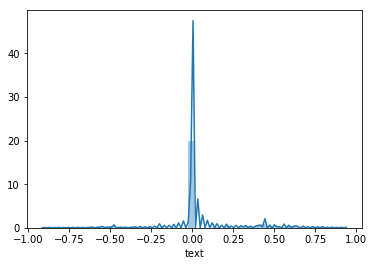

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(corpus_sentiment)
plt.show()

In [53]:
def relabel_sentiment(num):
    if num > 0:
        return 'positive'
    if num < 0:
        return 'negative'
    if num == 0:
        return 'neutral'
    
category_sentiment = corpus_sentiment.apply(relabel_sentiment)

In [54]:
category_sentiment.value_counts()

neutral     6504
positive    1588
negative     695
Name: text, dtype: int64